In [ ]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Model
from keras.applications import MobileNetV3Small
from keras.applications import MobileNetV3Large
from keras.applications import MobileNetV2
from keras.applications import EfficientNetV2S

# Model training
from keras import Sequential
from keras.layers import Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Model

# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from tqdm import tqdm

In [ ]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 128
IMAGE_SIZE = 224
gender_mapping = ["Male", "Female"]

In [ ]:
colab=True
try:
  from google.colab import drive
except:
  colab =False
if colab :
    drive.mount('/content/drive')
    print('g-drive mounted.')
else : print('local drive.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
g-drive mounted.


In [ ]:
dir_path = "/content/drive/MyDrive/files/0716-sampling3/"
image_path = os.listdir(dir_path)

In [ ]:
n_image_path = []
for path in image_path:
  age = int(path.split("_")[0])
  if age <= 80:
    n_image_path.append(path)
image_path = n_image_path

In [ ]:
# SHuffling the Images
np.random.shuffle(image_path)

# Split data into training, testing and validation set
train_images, test_images = train_test_split(
    image_path,
    train_size = 0.9,
    test_size = 0.1
)

print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")

NORM = 120

# def one_hot_encode(labels):
#     n_classes = 2
#     one_hot_encoded = np.eye(n_classes)[labels]
#     return one_hot_encoded

# Extract age and gender
train_ages = np.array([int(path.split("_")[0]) for path in train_images])
# train_ages = tf.cast(train_ages, tf.float32)/NORM
train_genders = np.array([int(path.split("_")[1]) for path in train_images])
# train_genders = tf.cast(one_hot_encode(train_genders), tf.float32)

test_ages = np.array([int(path.split("_")[0]) for path in test_images])
# test_ages = tf.cast(test_ages, tf.float32)/NORM
test_genders = np.array([int(path.split("_")[1]) for path in test_images])
# test_genders = tf.cast(one_hot_encode(test_genders), tf.float32)

Training Size : 5413
Testing Size  : 602


In [ ]:
# from tensorflow.keras.utils import to_categorical
# train_genders = to_categorical(train_genders, num_classes=2)
# test_genders = to_categorical(test_genders, num_classes=2)

In [ ]:
def show_image(image, show=False):
    """
    Displays the provided image without axis.

    Args:
    - image (array-like): The image data to be displayed.
    - show (bool): If True, displays the image immediately. Defaults to False.

    Returns:
    - None
    """
    plt.imshow(image)
    plt.axis("off")

    if show:
        plt.show()

def preprocess_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    """
    Preprocesses an image for analysis by extracting age and gender from the image path,
    loading and decoding the image, resizing it to (IMAGE_SIZE,IMAGE_SIZE), normalizing pixel values,
    and returning the preprocessed image along with age and gender labels.

    Args:
    - image_path (str): The path to the image file.
    - dir_path (str): The directory path where the image is located. Defaults to `dir_path`.

    Returns:
    - tuple: A tuple containing the preprocessed image as a TensorFlow tensor,
             the age (int), and the gender (int) extracted from the image path.
    """
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return (image, {'AgeOutput': age, 'GenderOutput': gender})




In [ ]:
# Obtain training, testing and validation datasets
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_single_ds = train_ds.map(preprocess_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_single_ds = test_ds.map(preprocess_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Conv2D
base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet")

# 백본 가중치 고정
base_model.trainable = False

# 입력 레이어 정의
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput")

# 백본 모델 적용
x = base_model(inputs)

# 공통 레이어 추가
x = Dropout(0.4, name="SlightDropout")(x)

# 나이 예측을 위한 분기
# age_conv = Conv2D(16, (3, 3), padding='same', activation='relu', name="AgeConv")(x)
# age_branch = Flatten(name="FlattenEmbeddings")(age_conv)
age_branch = Flatten(name="FlattenEmbeddings")(x)
age_output = Dense(1, activation="linear", name="AgeOutput")(age_branch)

# 성별 예측을 위한 분기
# gender_conv = Conv2D(8, (3, 3), padding='same', activation='relu', name="GenderConv")(x)
# gender_branch = GlobalAveragePooling2D(name="GlobalAvgPooling")(gender_conv)
gender_branch = GlobalAveragePooling2D(name="GlobalAvgPooling")(x)
gender_output = Dense(1, activation="sigmoid", name="GenderOutput")(gender_branch)
# gender_output = Dense(2, activation="softmax", name="GenderOutput")(gender_branch) #classification

# 최종 모델 정의
model = Model(inputs=inputs, outputs=[age_output, gender_output], name="AgeGenderNet")

# 모델 컴파일
model.compile(
    loss={'AgeOutput': 'mae', 'GenderOutput': 'mae'},
    optimizer='adam',
    metrics={'AgeOutput': 'mae', 'GenderOutput': 'accuracy'},
    weighted_metrics={'AgeOutput': [], 'GenderOutput': []}
)

# 모델 요약 출력
model.summary()

Model: "AgeGenderNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ImageInput (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['ImageInput[0][0]']          
 tional)                                                                                          
                                                                                                  
 SlightDropout (Dropout)     (None, 7, 7, 1280)           0         ['mobilenetv2_1.00_224[0][0]']
                                                                                                  
 FlattenEmbeddings (Flatten  (None, 62720)                0         ['SlightDropout[0][

In [ ]:
# Trining the Age Model
history = model.fit(
    train_single_ds,
    validation_data = test_single_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        ModelCheckpoint(
            "age-gender-mov2.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20
43/43 [==============================] - 28s 573ms/step - loss: 15.0381 - AgeOutput_loss: 14.6023 - GenderOutput_loss: 0.4358 - AgeOutput_mae: 14.6023 - GenderOutput_accuracy: 0.5941 - val_loss: 11.7543 - val_AgeOutput_loss: 11.3833 - val_GenderOutput_loss: 0.3709 - val_AgeOutput_mae: 11.3833 - val_GenderOutput_accuracy: 0.6711
Epoch 2/20
43/43 [==============================] - 18s 429ms/step - loss: 10.3751 - AgeOutput_loss: 10.0442 - GenderOutput_loss: 0.3309 - AgeOutput_mae: 10.0442 - GenderOutput_accuracy: 0.7201 - val_loss: 10.7759 - val_AgeOutput_loss: 10.4476 - val_GenderOutput_loss: 0.3283 - val_AgeOutput_mae: 10.4476 - val_GenderOutput_accuracy: 0.7143
Epoch 3/20
43/43 [==============================] - 19s 439ms/step - loss: 9.1017 - AgeOutput_loss: 8.8022 - GenderOutput_loss: 0.2995 - AgeOutput_mae: 8.8022 - GenderOutput_accuracy: 0.7393 - val_loss: 10.8107 - val_AgeOutput_loss: 10.4985 - val_GenderOutput_loss: 0.3121 - val_AgeOutput_mae: 10.4985 - val_GenderOutp

In [ ]:
save_dir = '/content/drive/MyDrive/files/save/'
cpCmd = f'cp {"age-gender-mov2.keras"} {save_dir}age-gender-mov2-1.keras'
print(cpCmd)
!{cpCmd}

cp age-gender-mov2.keras /content/drive/MyDrive/files/save/age-gender-mov2-1.keras


Total number of images  : 6015
Sample Image path       : 30_0_2_20170116192711273.jpg.chip.jpg
Sample Age              : 30
Sample Gender           : Male



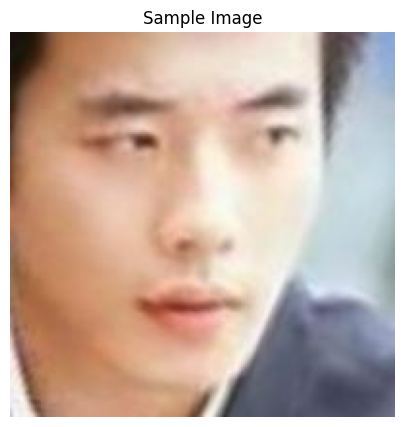

[[0.02418143]]
24.97 Male


<ipython-input-101-898521c00ee6>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_gender = int(np.round(pred_gender))


In [ ]:
rand_image_path = np.random.choice(image_path)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_path)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

# Show the image
plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()
# Load the Image
image = tf.io.read_file(dir_path + rand_image_path)
image = tf.io.decode_jpeg(image)
# Resize and Normalize the Image
image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
image = image / 255.
image = tf.cast(image, tf.float32)
image = tf.reshape(image, [-1,224,224,3])
pred_age, pred_gender = model.predict(image,verbose=0)
print(pred_gender)
pred_age = np.round(np.squeeze(pred_age),2)
pred_gender = int(np.round(pred_gender))
print(pred_age, gender_mapping[pred_gender])

In [ ]:
# Loading saved models
# model_best = tf.keras.models.load_model("/content/drive/MyDrive/files/save/age-gender-mov2.keras", compile=True)

SyntaxError: invalid syntax (<ipython-input-61-a26e66e324a4>, line 1)

<ipython-input-65-ef5866a8963d>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_gender = int(np.round(pred_gender))


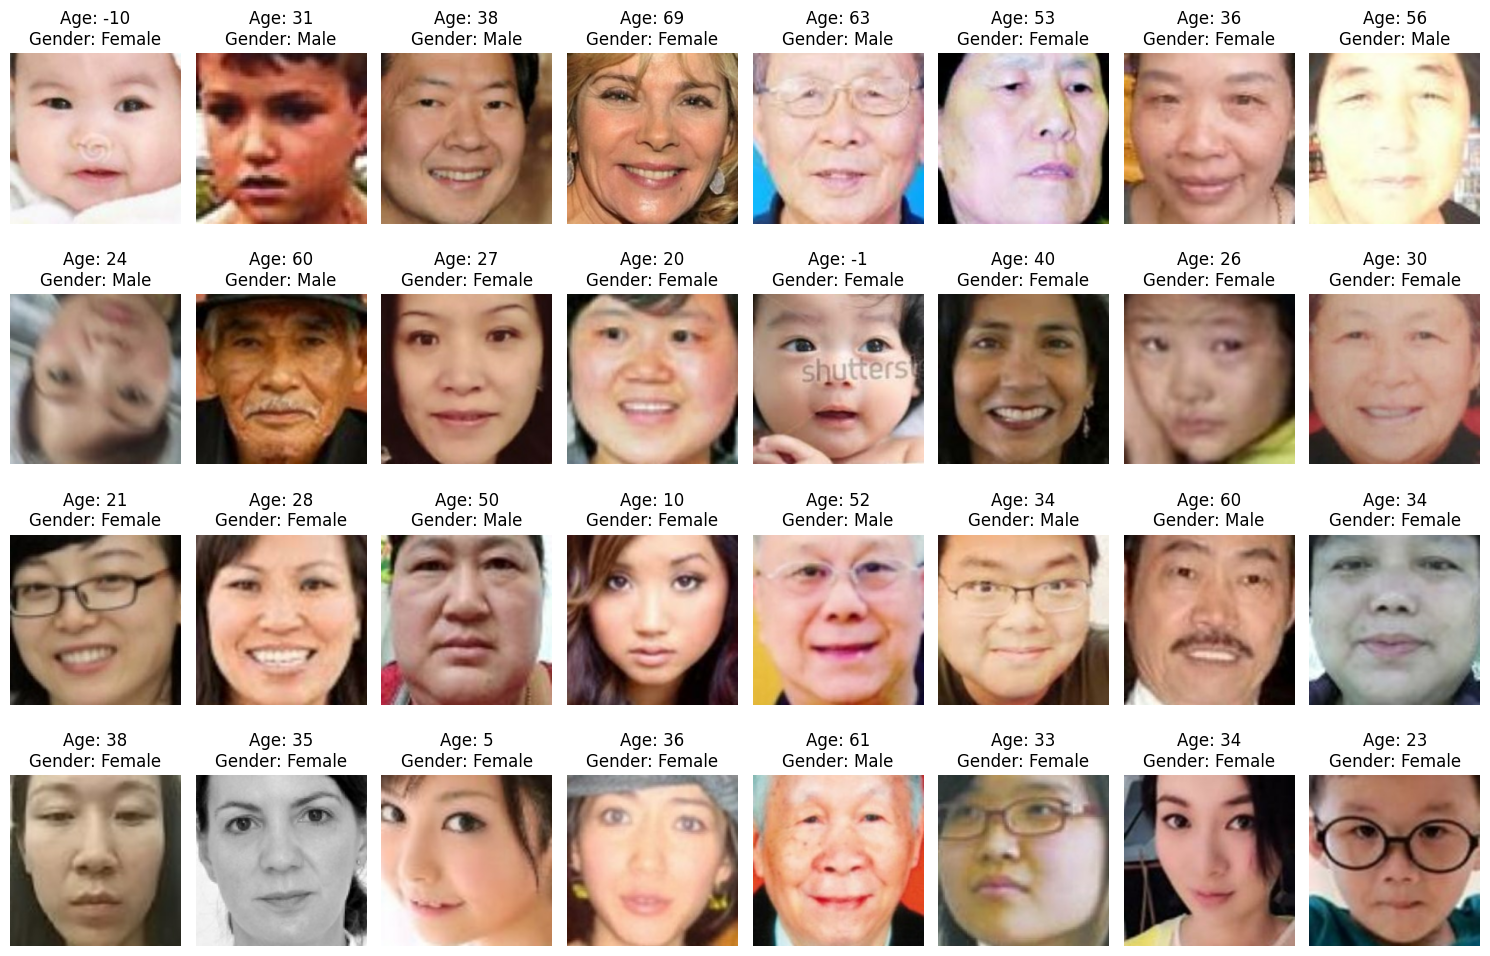

In [ ]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(32).take(1):
    for index in range(len(images)):

        # Image Processing
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])

        # Predictions
        pred_age, pred_gender = model.predict(image,verbose=0)
        pred_age = int(np.round(np.squeeze(pred_age)))
        pred_gender = int(np.round(pred_gender))

        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Age: {pred_age}\nGender: {gender_mapping[pred_gender]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
from google.colab import output
from IPython.display import display, Javascript
from ipywidgets import widgets
import cv2
import numpy as np
import mediapipe as mp
import math
import base64

# Mediapipe의 얼굴 검출 모듈 초기화
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# JavaScript를 사용하여 웹캠 영상을 캡처하는 함수
def capture_image():
    js = Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            return canvas.toDataURL('image/jpeg');
        }
        captureImage();
    ''')
    display(js)
    data = output.eval_js('captureImage()')
    return data

# 캡처된 이미지를 디코딩하는 함수
def data_uri_to_image(data_uri):
    header, encoded = data_uri.split(",", 1)
    data = np.frombuffer(base64.b64decode(encoded), dtype=np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return image

# 얼굴 방향 각도 계산 함수
def calculate_yaw_angle(detection):
    landmarks = detection.location_data.relative_keypoints
    left_eye = landmarks[mp_face_detection.FaceKeyPoint.LEFT_EYE]
    right_eye = landmarks[mp_face_detection.FaceKeyPoint.RIGHT_EYE]
    nose = landmarks[mp_face_detection.FaceKeyPoint.NOSE_TIP]
    eye_center_x = (left_eye.x + right_eye.x) / 2
    eye_center_y = (left_eye.y + right_eye.y) / 2
    nose_x = nose.x
    nose_y = nose.y
    angle_rad = math.atan2(eye_center_y - nose_y, eye_center_x - nose_x)
    angle_deg = math.degrees(angle_rad) + 90
    return angle_deg

# Mediapipe 얼굴 검출 모델 초기화
with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5) as face_detection:
    while True:
        data = capture_image()
        image = data_uri_to_image(data)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)
        if results.detections:
            for detection in results.detections:
                angle_deg = calculate_yaw_angle(detection)
                bboxC = detection.location_data.relative_bounding_box
                if bboxC is None:
                    break
                ih, iw, _ = image.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                if x < 0 or y < 0 or w > iw or h > ih:
                    break
                detected_image = image[y:y+h, x:x+w]
                detected_image = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)
                input_data = tf.image.resize(detected_image, [224,224])
                input_data = tf.reshape(input_data, [-1,224,224,3])
                input_data = input_data/255.0
                pred_age, pred_gender = model.predict(input_data,verbose=0)
                pred_age = int(np.round(np.squeeze(pred_age)))
                pred_gender = int(np.round(pred_gender))
                cv2.putText(image, f"AGE: {pred_age}", (x, y-7),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.putText(image, f"GENDER: {'M' if pred_gender==0 else 'W'}", (x, y-32),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.putText(image, f"Angle: {angle_deg:.2f} °", (x, y - 62), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                mp_drawing.draw_detection(image, detection)
        _, img_encoded = cv2.imencode('.jpg', image)
        img_bytes = img_encoded.tobytes()
        display(widgets.Image(value=img_bytes))

<IPython.core.display.Javascript object>

<ipython-input-66-9647a628825a>:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_gender = int(np.round(pred_gender))


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
detected_image